In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz
import numpy as np
from sklearn import preprocessing

In [2]:
full_results = pd.read_csv('full_results.csv')
full_stats = pd.read_csv('FullKenPom_pt.csv')

print(full_results.shape)
print(full_stats.shape)

(1112, 11)
(1129, 27)


In [3]:
###mask test and train data###
res_test_mask = (full_results['Year'] == 2016) | (full_results['Year'] == 2017) | (full_results['Year'] == 2018)
stats_test_mask = (full_stats['Season'] == 2016) | (full_stats['Season'] == 2017) | (full_stats['Season'] == 2018)
res_train_mask = (full_results['Year'] < 2016)
stats_train_mask = (full_stats['Season'] < 2016)

res_data_test = full_results[res_test_mask]
stats_data_test = full_stats[stats_test_mask]
res_data_train = full_results[res_train_mask]
stats_data_train = full_stats[stats_train_mask]

#reindex all of them
res_data_test = res_data_test.reset_index()
stats_data_test = stats_data_test.reset_index()
res_data_train = res_data_train.reset_index()
stats_data_train = stats_data_train.reset_index()

for i in range(len(res_data_test)):
    if res_data_test['Region Name'][i] == "First Four":
        res_data_test = res_data_test.drop(i)
for i in range(len(res_data_train)):
    if res_data_train['Region Name'][i] == "First Four":
        res_data_train = res_data_train.drop(i)
        
#reindex all of them
res_data_test = res_data_test.reset_index()
stats_data_test = stats_data_test.reset_index()
res_data_train = res_data_train.reset_index()
stats_data_train = stats_data_train.reset_index()

res_data_train.head()

#res_data_test.tail()
#stats_data_test.tail()
#res_data_train.tail()
#stats_data_train.tail()


,level_0,index,Unnamed: 0,Year,Round,Region Number,Region Name,SeedA,ScoreA,TeamA,TeamB,ScoreB,SeedB
0,1,1,1,2002,1,1,South,1,84,Duke,Winthrop,37,16
1,2,2,2,2002,1,1,South,2,86,Alabama,Florida Atlantic,78,15
2,3,3,3,2002,1,1,South,3,71,Pittsburgh,Central Connecticut St,54,14
3,4,4,4,2002,1,1,South,4,89,USC,UNC Wilmington,93,13
4,5,5,5,2002,1,1,South,5,75,Indiana,Utah,56,12


In [4]:
#these names match the kenpom stats csv
stats_vec = ["AdjTempo",
            "AdjOE",
            "AdjDE",
            "AdjEM",
            "seed",
            "ConfTournament",
            "SOSAdjEM",
            "NCSOSAdjEM",
            "O-D_eFG_Pct",
            "D-O_TO_Pct",
            "O-D_OR_Pct",
            "O-D_FT_Rate",
            "LastTenRecord"]

print(len(stats_vec))

13


In [5]:
# Move training data into 2 numpy arrays - data and labels (results)
N = len(res_data_train)

training_data = np.zeros((N,13))
training_labels = np.zeros((N,1))

for i in range(len(res_data_train)):
    year = res_data_train['Year'][i]
    teamA = res_data_train['TeamA'][i]
    teamB = res_data_train['TeamB'][i]
    score_diff = res_data_train['ScoreA'][i] - res_data_train['ScoreB'][i]
    for k in range(len(stats_data_train)):
        if ((stats_data_train['Season'][k] == year) and (stats_data_train['TeamName'][k] == teamA)):
            indexA = k
            break
            
    for k in range(len(stats_data_train)):
        if ((stats_data_train['Season'][k] == year) and (stats_data_train['TeamName'][k] == teamB)):
            indexB = k
            break
    for s in range(len(stats_vec)):
        stat = stats_vec[s]
        training_data[i][s] = stats_data_train[stat][indexA] - stats_data_train[stat][indexB]
    
    if (score_diff > 0): # team A won
        training_labels[i][0] = 1
    else:
        training_labels[i][0] = 0 #team B won


In [6]:
# Move testing data into 2 numpy arrays - data and labels (results)
N = len(res_data_test)

testing_data = np.zeros((N,13))
testing_labels = np.zeros((N,1))

for i in range(len(res_data_test)):
#for i in range(5):
    year = res_data_test['Year'][i]
    teamA = res_data_test['TeamA'][i]
    teamB = res_data_test['TeamB'][i]
    score_diff = res_data_test['ScoreA'][i] - res_data_test['ScoreB'][i]
    for k in range(len(stats_data_test)):
        if ((stats_data_test['Season'][k] == year) and (stats_data_test['TeamName'][k] == teamA)):
            indexA = k
            break
            
    for k in range(len(stats_data_test)):
        if ((stats_data_test['Season'][k] == year) and (stats_data_test['TeamName'][k] == teamB)):
            indexB = k
            break
    for s in range(len(stats_vec)):
        stat = stats_vec[s]
        testing_data[i][s] = stats_data_test[stat][indexA] - stats_data_test[stat][indexB]
    
    if (score_diff > 0):
        testing_labels[i][0] = 1
    else:
        testing_labels[i][0] = 0


In [7]:
print(training_data.shape)
print(training_labels.shape)
print('\n')
print(testing_data.shape)
print(testing_labels.shape)

(882, 13)
(882, 1)


(189, 13)
(189, 1)


In [8]:
#Time to normalize the data
training_data = preprocessing.normalize(training_data, axis=0, norm='max')
testing_data = preprocessing.normalize(testing_data, axis=0, norm='max')


In [9]:
dtrain = xgb.DMatrix(training_data, label=training_labels,
                     feature_names=stats_vec)
dtest = xgb.DMatrix(testing_data, label=testing_labels,
                    feature_names=stats_vec)


In [24]:
param = {'objective': 'multi:softprob'}
param['eval_metric'] = "merror"
param['num_class'] = 2  # 2 classes - win or loss

#evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 999 #looks like it levels off at around 200

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,8)
    for min_child_weight in range(1,6)
]
min_merror = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    
    # Update Parameters
    param['max_depth'] = max_depth
    param['min_child_weight'] = min_child_weight
    
    #Run CV
    cv_results = xgb.cv(param,
                        dtrain,
                        num_boost_round=num_round, #maybe wrong
                        seed=42,
                        nfold=3,
                        metrics={'merror'},
                        early_stopping_rounds=10)
    
    #Update best MError
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tMerror {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = (max_depth, min_child_weight)
    

param['max_depth'] = best_params[0]
param['min_child_weight'] = best_params[1]


CV with max_depth=1, min_child_weight=1
	Merror 0.2834466666666667 for 0 rounds
CV with max_depth=1, min_child_weight=2
	Merror 0.2834466666666667 for 0 rounds
CV with max_depth=1, min_child_weight=3
	Merror 0.2834466666666667 for 0 rounds
CV with max_depth=1, min_child_weight=4
	Merror 0.2834466666666667 for 0 rounds
CV with max_depth=1, min_child_weight=5
	Merror 0.2834466666666667 for 0 rounds
CV with max_depth=2, min_child_weight=1
	Merror 0.27210866666666667 for 23 rounds
CV with max_depth=2, min_child_weight=2
	Merror 0.2732426666666667 for 20 rounds
CV with max_depth=2, min_child_weight=3
	Merror 0.26870733333333335 for 14 rounds
CV with max_depth=2, min_child_weight=4
	Merror 0.26757366666666665 for 18 rounds
CV with max_depth=2, min_child_weight=5
	Merror 0.2732426666666667 for 5 rounds
CV with max_depth=3, min_child_weight=1
	Merror 0.27097533333333335 for 2 rounds
CV with max_depth=3, min_child_weight=2
	Merror 0.26870733333333335 for 2 rounds
CV with max_depth=3, min_child_

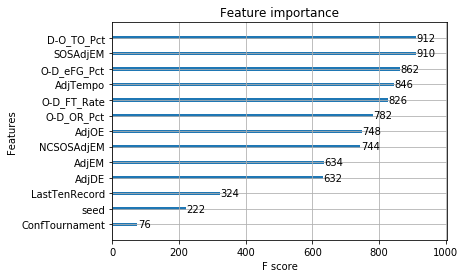

In [11]:
xgb.plot_importance(bst)

In [12]:
ypred = bst.predict(dtest)
ypred

array([[1.20055171e-04, 9.99879956e-01],
       [2.79563137e-05, 9.99971986e-01],
       [1.94901635e-03, 9.98051047e-01],
       [1.00666441e-01, 8.99333537e-01],
       [1.39910415e-01, 8.60089600e-01],
       [2.09241986e-01, 7.90758014e-01],
       [2.20595896e-02, 9.77940440e-01],
       [9.99168634e-01, 8.31407786e-04],
       [1.90402461e-05, 9.99980927e-01],
       [1.11866994e-02, 9.88813341e-01],
       [6.88784290e-04, 9.99311209e-01],
       [7.97263440e-03, 9.92027342e-01],
       [3.26021351e-02, 9.67397869e-01],
       [3.18005413e-01, 6.81994557e-01],
       [1.45156652e-01, 8.54843378e-01],
       [9.61072385e-01, 3.89276370e-02],
       [2.03922937e-05, 9.99979615e-01],
       [4.76832156e-06, 9.99995232e-01],
       [1.34686183e-03, 9.98653054e-01],
       [5.04186435e-04, 9.99495745e-01],
       [3.89347272e-03, 9.96106565e-01],
       [3.53426456e-01, 6.46573544e-01],
       [1.38039008e-01, 8.61961007e-01],
       [8.72243822e-01, 1.27756193e-01],
       [1.416604

In [13]:
print(ypred.shape)
print(testing_labels.shape)

(189, 2)
(189, 1)


In [20]:
correct_list = np.zeros_like(testing_labels)
for i in range(len(ypred)):
    if ypred[i][0] > ypred[i][1]:
        metric = 1 # team A predicted to win
    else:
        metric = 0
    correct_list[i][0] = metric
print("% Correct:", (correct_list.sum() / len(correct_list))*100)

% Correct: 17.989417989417987
